In [138]:
from collections import defaultdict, Counter
import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
TRIALS_CSV = "psiturk/trialdata.csv"
trials = pd.read_csv(TRIALS_CSV, header=None, names=["user_id", "trial_id", "time", "trial_data"])
trials.head()

,user_id,trial_id,time,trial_data
0,debugK6FBJC:debugJF0CZ9,0,1520453837246,"{""rt"": 1513, ""trial_type"": ""instructions"", ""vi..."
1,debugK6FBJC:debugJF0CZ9,1,1520453840309,"{""rt"": 3060, ""trial_type"": ""survey-text"", ""res..."
2,debugK6FBJC:debugJF0CZ9,2,1520453844577,"{""rt"": 4262, ""trial_type"": ""survey-multi-choic..."
3,debugK6FBJC:debugJF0CZ9,3,1520453845580,"{""rt"": null, ""trial_type"": ""html-keyboard-resp..."
4,debugK6FBJC:debugJF0CZ9,4,1520453848151,"{""rt"": 2568, ""trial_type"": ""scene-choice"", ""pr..."


## Demographics

In [3]:
users = defaultdict(dict)
for i, trial in trials.iterrows():
    tdata = json.loads(trial.trial_data)
    try:
        responses = json.loads(tdata["responses"])
    except KeyError:
        continue
        
    user_data = users[trial.user_id]
    if tdata["trial_type"] == "survey-text":
        if tdata["trial_index"] == 1:
            user_data["age"] = int(responses["Q0"])
        else:
            user_data["comments"] = responses["Q0"]
    elif tdata["trial_type"] == "survey-multi-choice":
        user_data["sex"] = responses["Q0"]
        user_data["education"] = responses["Q1"]
        user_data["native"] = responses["Q2"]
        
users = pd.DataFrame.from_dict(users, "index")
users.head()

,age,sex,education,native,comments
debugFAZXUC:debugELFLAW,25,Female,High school/GED,Yes,Hi
debugK6FBJC:debugJF0CZ9,18,Male,Bachelor's degree,Yes,


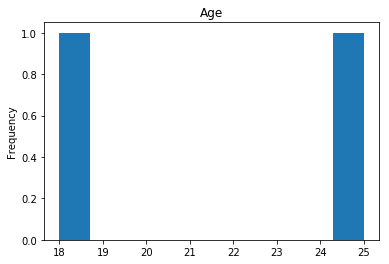

In [4]:
users.age.plot.hist(title="Age")

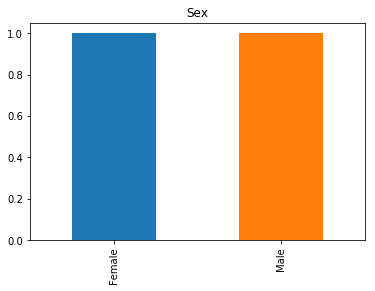

In [5]:
users.sex.value_counts().plot.bar(title="Sex")

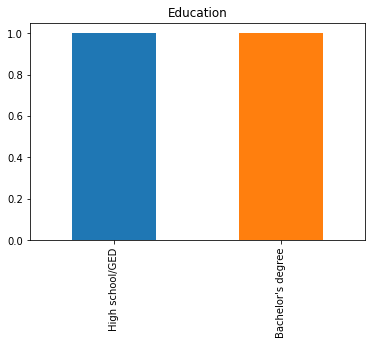

In [6]:
users.education.value_counts().plot.bar(title="Education")

In [7]:
list(users.comments.unique())

['Hi', '']

## Data prep

In [45]:
trials_parsed = [(i, json.loads(trial.trial_data)) for i, trial in trials.iterrows()]
exp_trials = [(i, trial) for i, trial in trials_parsed if trial["trial_type"] == "scene-choice"]
exp_trials[:5]

[(4,
  {'choice': 'C',
   'frame': 'mancar-02',
   'frame_path': 'mancar-02.png',
   'internal_node_id': '0.0-4.0',
   'labeled_frame_path': 'mancar-02.08.png',
   'prompt': "I'm looking for my friend. He is the one standing in front of the car. Which one is my friend?",
   'prompt_type': 'pick',
   'referents': {'A': ['wall', None],
    'B': ['motorhaube', None],
    'C': ['uomo2', 'intrinsic'],
    'D': ['uomo', 'relative']},
   'relation': 'in front of',
   'rt': 2568,
   'scene': 'mancar',
   'time_elapsed': 12420,
   'trial_index': 4,
   'trial_type': 'scene-choice'}),
 (6,
  {'choice': 'A',
   'frame': 'mantv-02',
   'frame_path': 'mantv-02.png',
   'internal_node_id': '0.0-6.0',
   'labeled_frame_path': 'mantv-02.01.png',
   'prompt': "I'm looking for my friend. He is the one who is standing near the television. Which is my friend?",
   'prompt_type': 'pick',
   'referents': {'A': ['uomo2', None],
    'B': ['uomo', 'relative'],
    'C': ['Hat Lamp.jpg', None]},
   'relation': 'n

Unfortunately the referents are missing their frame-of-reference labels for some reason – they didn't get properly exported from Blender.

I'll manually insert the correct referent frames based on the current data.

In [129]:
frame_fixes = {
    "manbus-01": {"Ruomo2": "functional", "Ruomo": "relative"},
    "manbus-02": {"Ruomo2": "functional", "Ruomo": "intrinsic"},
    "manbus-03": {"Ruomo2": "relative", "Ruomo": "intrinsic"},
    "manbus-04": {"Ruomo2": "relative", "Ruomo": "functional"},
    "manbus-05": {"Ruomo2": "relative", "Ruomo": None},
    
    # TODO maybe manbus 6+ should be deleted? old camera angle
    "manbus-06": {"uomo2": "intrinsic", "uomo": "functional"},
    "manbus-07": {"uomo2": "relative", "uomo": "functional"},
    
    "mantv-01": {"uomo2": "functional", "uomo": "relative"},
    "mantv-02": {"uomo2": "intrinsic", "uomo": "relative"},
    "mantv-03": {"uomo2": "intrinsic", "uomo": "functional"},
    "mantv-04": {"uomo2": "intrinsic"},
    "mantv-05": {"uomo2": "functional"},
    "mantv-06": {"uomo2": "relative"},
    "mantv-07": {"uomo": "functional"},
    "mantv-08": {"uomo": "relative"},
    "mantv-09": {"uomo": "intrinsic"},
}

for i, trial in exp_trials:
    if trial["frame"] in frame_fixes:
        for referent_data in trial["referents"].values():
            fixes = frame_fixes[trial["frame"]]
            if referent_data[0] in fixes:
                if referent_data[1] is not None:
                    # sanity check
                    assert fixes[referent_data[0]] == referent_data[1]
                referent_data[1] = fixes[referent_data[0]]

## Sanity check: filler trials

In [130]:
def get_humans(trial):
    return [(key, referent) for key, referent in trial["referents"].items()
            if referent[0].startswith(("uomo", "Ruomo"))]

fillers = []
for i, trial in exp_trials:
    if trial["relation"] == "near":
        humans = get_humans(trial)
        if trial["prompt_type"] == "count":
            fillers.append((trials.iloc[i].user_id, trial["choice"], len(humans)))
        elif trial["prompt_type"] == "pick" and len(humans) == 1:
            fillers.append((trials.iloc[i].user_id, trial["choice"], humans[0][0]))
            
fillers = pd.DataFrame(fillers, columns=["user_id", "choice", "ground_truth"])
fillers = fillers.assign(correct=(fillers.choice == fillers.ground_truth).astype(int))
fillers.head()

,user_id,choice,ground_truth,correct
0,debugK6FBJC:debugJF0CZ9,A,A,1
1,debugFAZXUC:debugELFLAW,A,A,1
2,debugFAZXUC:debugELFLAW,B,B,1
3,debugFAZXUC:debugELFLAW,1,1,1


Mean accuracy on filler elements:

In [131]:
fillers["correct"].mean()

1.0

Grouped by subject:

In [132]:
fillers_user_perf = fillers.groupby("user_id").correct.agg("mean")
fillers_user_perf.describe()

count    2.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: correct, dtype: float64

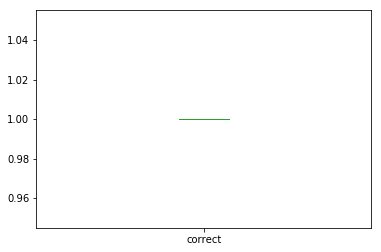

In [133]:
fillers_user_perf.plot.box()

## Sanity check: never choose non-humans

In [146]:
user_non_human_choices = {}
for i, exp_trial in exp_trials:
    user_id = trials.iloc[i].user_id
    u_choices = user_non_human_choices.get(user_id, 0)
    
    trial_humans = get_humans(trial)
    
    if trial["prompt_type"] == "pick":
        trial_choice_referent = trial["referents"][trial["choice"]]
        if trial_choice_referent not in trial_humans:
            u_choices += 1
    elif trial["prompt_type"] == "count":
        if trial["choice"] > len(trial_humans):
            u_choices += 1
            
    user_non_human_choices[user_id] = u_choices
        
pd.DataFrame.from_dict(user_non_human_choices, "index")

,0
debugK6FBJC:debugJF0CZ9,0
debugFAZXUC:debugELFLAW,0


## *In front of*: Two-place oppositions

The first and simplest question: when two different senses come in conflict with the prompt relation "in front of", which wins?

In [134]:
senses = ["intrinsic", "relative", "functional"]

opp_scenes = defaultdict(list)
for i, trial in exp_trials:
    if trial["relation"] != "in front of":
        continue
        
    humans = get_humans(trial)
    frames = [trial["referents"][key][1] for key, _ in humans]
    if None not in frames and len(set(frames)) == 2:
        opp_key = tuple(sorted(frames))
        opp_scenes[opp_key].append((i, trial))
        
opp_scenes

defaultdict(list,
            {('functional',
              'relative'): [(8,
               {'choice': 1,
                'frame': 'mancar-01',
                'frame_path': 'mancar-01.png',
                'internal_node_id': '0.0-8.0',
                'labeled_frame_path': 'mancar-01.23.png',
                'prompt': 'How many people are standing in front of the car?',
                'prompt_type': 'count',
                'referents': {'A': ['uomo', 'functional'],
                 'B': ['motorhaube', None],
                 'C': ['wall', None],
                 'D': ['uomo2', 'relative']},
                'relation': 'in front of',
                'rt': 1974,
                'scene': 'mancar',
                'time_elapsed': 18578,
                'trial_index': 8,
                'trial_type': 'scene-choice'}), (27,
               {'choice': 1,
                'frame': 'mancar-01',
                'frame_path': 'mancar-01.png',
                'internal_node_id': '0.0-12.0',
   

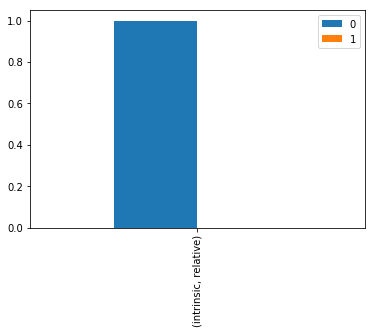

In [135]:
# For "pick" scenes, which sense wins?
opp_pick_choices = defaultdict(lambda: {0: 0, 1: 0})
for (s1, s2), opp_trials in opp_scenes.items():
    for i, trial in opp_trials:
        if trial["prompt_type"] == "pick":
            chosen_frame = trial["referents"][trial["choice"]][1]
            chosen_frame_idx = 0 if chosen_frame == s1 else 1
            opp_pick_choices[s1, s2][chosen_frame_idx] += 1
            
opp_pick_choices = pd.DataFrame.from_dict(opp_pick_choices, "index")
opp_pick_choices.plot.bar()

## *In front of*: Counting

Let's look at scenes where multiple humans are "in front of" a ground object in different senses.

Do people consider all senses of "in front of" when counting?

- If so, we should see a pattern along $x = y$ in the scatter plot.
- If not, we should regularly see a count of 1 in the scatter plot. (There is only ever one human satisfying any single sense in a given scene.)

(-0.15, 2.15)

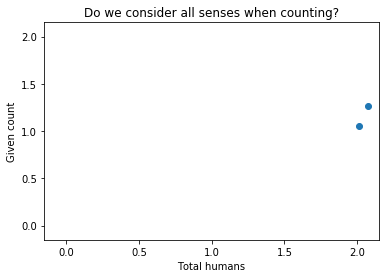

In [136]:
front_count_trials = [(i, trial) for i, trial in exp_trials
                      if trial["prompt_type"] == "count" and trial["relation"] == "in front of"]
# NB: jitter
plt.scatter([len([human for human, sense in get_humans(trial) if sense != None]) + np.random.random() * 0.1 for i, trial in front_count_trials],
            [trial["choice"] + np.random.random() * 0.3 for i, trial in front_count_trials])
plt.xlabel("Total humans")
plt.ylabel("Given count")
plt.title("Do we consider all senses when counting?")
plt.xlim((-0.15, 2.15))
plt.ylim((-0.15, 2.15))

## *Near*: what sense?

What sense are people using when answering "near" prompts?

In [127]:
near_pick_trials = [(i, trial) for i, trial in exp_trials
                    if trial["prompt_type"] == "pick" and trial["relation"] == "near"]
near_pick_senses = [trial["referents"][trial["choice"]][1] for i, trial in near_pick_trials]
print(near_pick_senses)
near_pick_trials

[None, None, 'relative', 'intrinsic', None, None]


[(6,
  {'choice': 'A',
   'frame': 'mantv-02',
   'frame_path': 'mantv-02.png',
   'internal_node_id': '0.0-6.0',
   'labeled_frame_path': 'mantv-02.01.png',
   'prompt': "I'm looking for my friend. He is the one who is standing near the television. Which is my friend?",
   'prompt_type': 'pick',
   'referents': {'A': ['uomo2', None],
    'B': ['uomo', 'relative'],
    'C': ['Hat Lamp.jpg', None]},
   'relation': 'near',
   'rt': 2179,
   'scene': 'mantv',
   'time_elapsed': 15600,
   'trial_index': 6,
   'trial_type': 'scene-choice'}),
 (10,
  {'choice': 'A',
   'frame': 'mantv-05',
   'frame_path': 'mantv-05.png',
   'internal_node_id': '0.0-10.0',
   'labeled_frame_path': 'mantv-05.00.png',
   'prompt': "I'm looking for my friend. He is the one who is standing near the television. Which is my friend?",
   'prompt_type': 'pick',
   'referents': {'A': ['uomo2', None], 'B': ['Hat Lamp.jpg', None]},
   'relation': 'near',
   'rt': 4391,
   'scene': 'mantv',
   'time_elapsed': 23972,
   

## TODO

It looks like frame-of-reference data is missing from both `mantv` and `manbus` .. need to rebuild these JSON files, and then load that data here :/